In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#In this approach I'm going to follw the all steps from Kaggle article(https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)
# In this data, the drop time and pickup time where dropped.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/content/gdrive/My Drive/ML Project Taxi Fair/train.csv')
df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [ ]:
#Before do describe, Let's convert the label as 1 and 0 .(1-correct and 0-incorrect)
def encoding_label(label):
  if(label=='correct'):
    return 1
  else:
    return 0

df['label']= df['label'].apply(encoding_label).values

In [ ]:
df.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000,17176.000000
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466,0.902131
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565,0.297146
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,0.000000
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000,1.000000
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000,1.000000
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000,1.000000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,1.000000


In [ ]:
#Find null values
df.isnull().sum().max()

202

In [ ]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data['Percent'] = missing_data['Percent'].apply(lambda x: "{0} %".format(round(x,2)))
missing_data.head(20)

,Total,Percent
meter_waiting_till_pickup,202,1.18 %
meter_waiting_fare,202,1.18 %
meter_waiting,202,1.18 %
duration,202,1.18 %
additional_fare,202,1.18 %
fare,137,0.8 %
label,0,0.0 %
drop_lon,0,0.0 %
drop_lat,0,0.0 %
pick_lon,0,0.0 %


In [ ]:
#No NaN filling this time . Just remove  NaN valued rows.
df.dropna(subset=['additional_fare','duration','meter_waiting','meter_waiting_fare','meter_waiting_till_pickup','fare'], inplace=True)

In [ ]:
#Oh no forget the tripid
df.drop(columns=['tripid'], inplace=True)

In [ ]:
df.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label'],
      dtype='object')

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('Correct', round(df['label'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('In correct', round(df['label'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Correct 91.01 % of the dataset
In correct 8.99 % of the dataset


In [ ]:
#As I said earlier , This time drop the pick_time and drop_time
df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

Text(0.5, 1.0, 'Class Distributions \n (0: In correct || 1: Correct)')

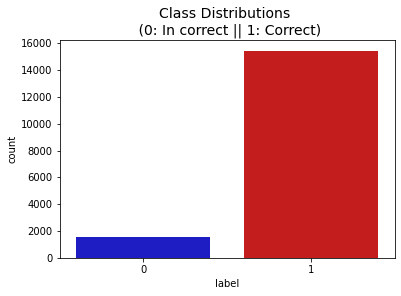

In [ ]:
#Label distribution
colors = ["#0101DF", "#DF0101"]

sns.countplot('label', data=df, palette=colors)
plt.title('Class Distributions \n (0: In correct || 1: Correct)', fontsize=14)

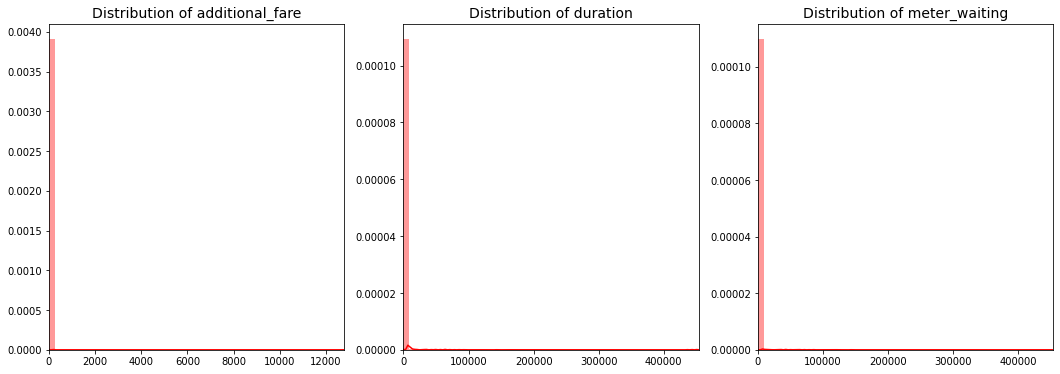

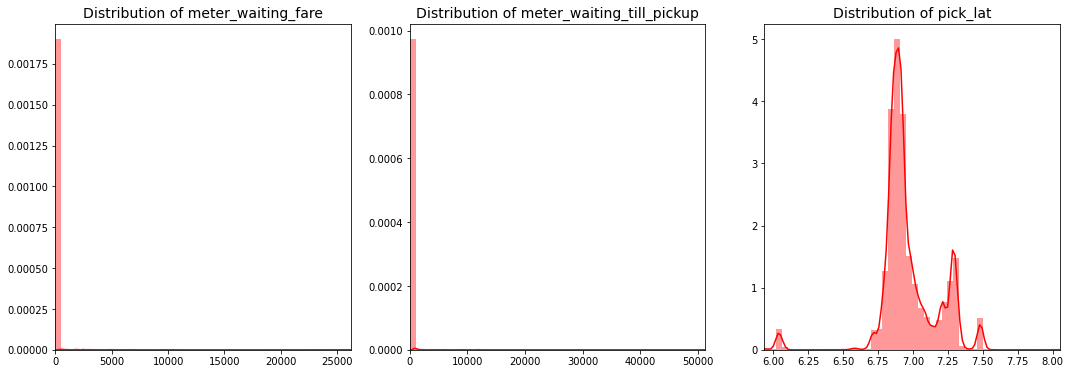

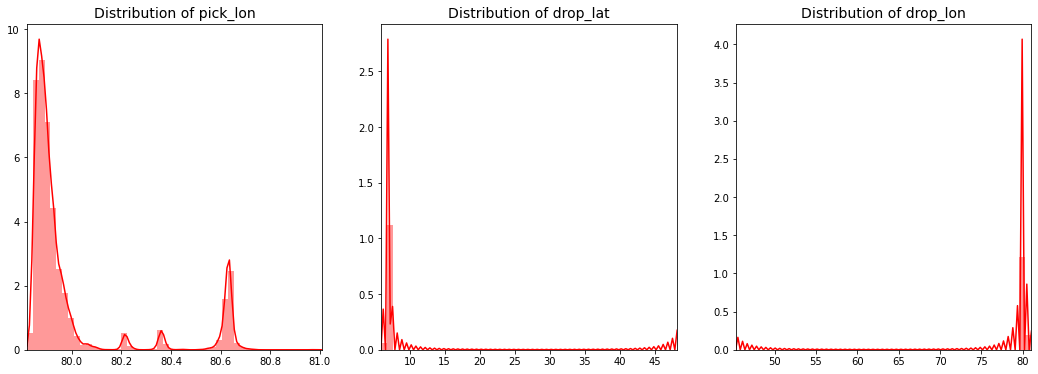

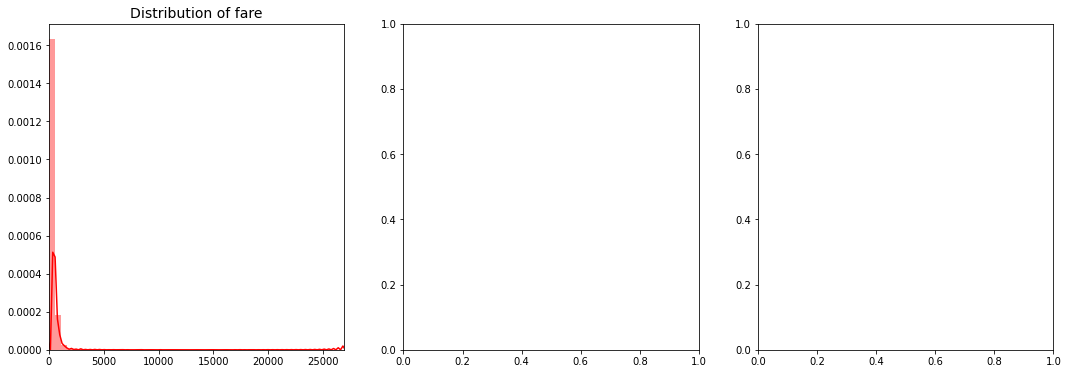

In [ ]:


columns = df.columns

for idx in range(0,12,3):
  fig, (ax) = plt.subplots(1, 3, figsize=(18,6))

  for k in range(0,3):
    if(idx+k==10):
      break
    _val = df[columns[idx+k]].values

    sns.distplot(_val, ax=ax[k], color='r')
    ax[k].set_title('Distribution of {0}'.format(columns[idx+k]), fontsize=14)
    ax[k].set_xlim([min(_val), max(_val)])

plt.show()

In [ ]:
# Scale all the features
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

columns = df.columns

for column in columns:
  if(column=="label"):
    continue
  new_column = "scaled_{0}".format(column)
  df[new_column] = rob_scaler.fit_transform(df[column].values.reshape(-1,1))
  df.drop([column], axis=1, inplace=True)

In [ ]:
df.head()

,label,scaled_additional_fare,scaled_duration,scaled_meter_waiting,scaled_meter_waiting_fare,scaled_meter_waiting_till_pickup,scaled_pick_lat,scaled_pick_lon,scaled_drop_lat,scaled_drop_lon,scaled_fare
0,1,0.0,-0.139526,-0.210692,-0.008065,-0.076271,-0.289260,0.008137,-0.069844,-0.230256,0.246235
1,1,0.0,-0.173809,-0.238994,-0.008065,0.516949,-0.157870,-0.002325,-0.012212,-0.074527,-0.054839
2,1,0.0,0.062189,-0.135220,-0.008065,-0.101695,-0.031372,-0.389422,0.114657,0.173526,0.376353
3,1,0.0,-0.327686,0.465409,1.084677,-0.042373,0.065948,-0.105783,0.063766,-0.021135,-0.534887
5,1,0.0,1.911900,0.185535,-0.008065,0.330508,1.237157,-0.019762,0.014974,-0.379310,3.547787


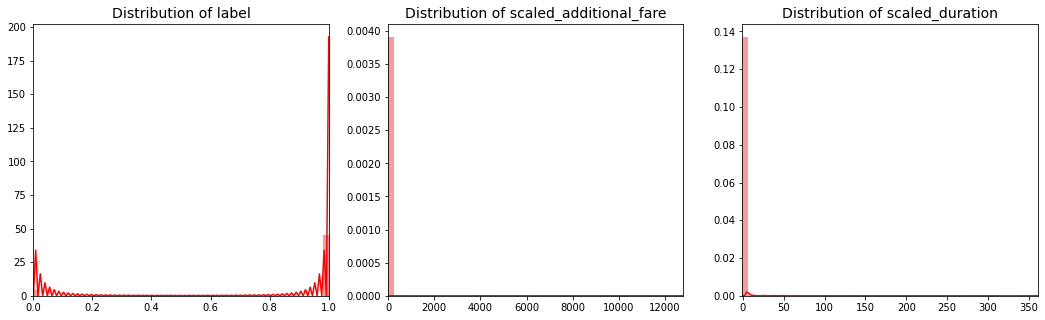

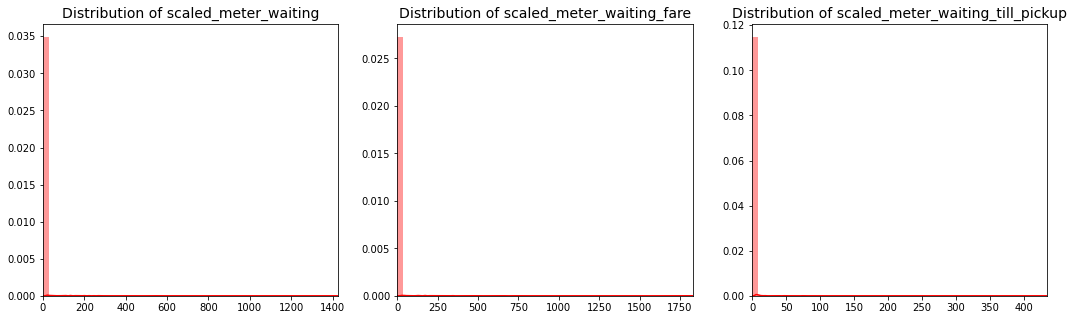

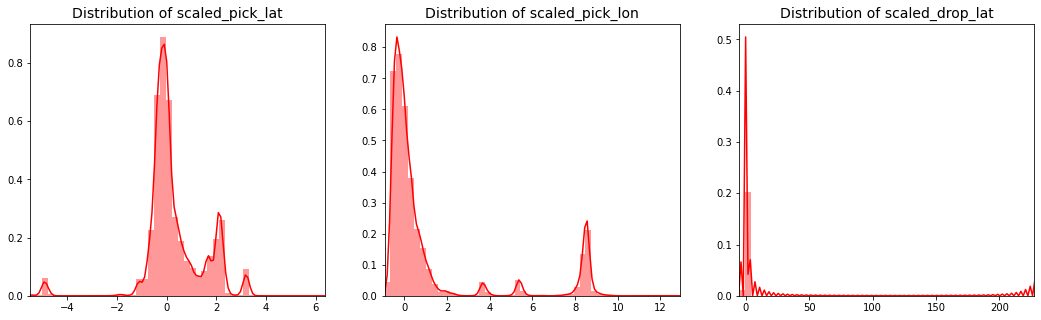

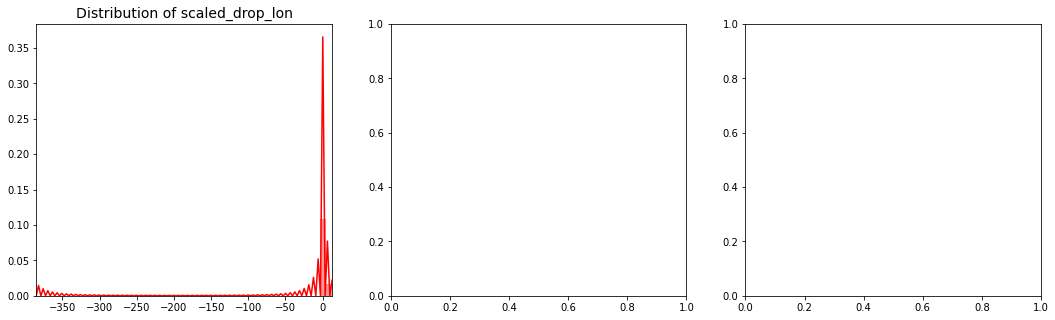

In [ ]:
#Plot new Distributions
columns = df.columns
for idx in range(0,12,3):
  fig, (ax) = plt.subplots(1, 3, figsize=(18,5))

  for k in range(0,3):
    if(idx+k==10):
      break
    _val = df[columns[idx+k]].values

    sns.distplot(_val, ax=ax[k], color='r')
    ax[k].set_title('Distribution of {0}'.format(columns[idx+k]), fontsize=14)
    ax[k].set_xlim([min(_val), max(_val)])

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('In correct', round(df['label'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Correct', round(df['label'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('label', axis=1)
y = df['label']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

In correct 8.99 % of the dataset
Correct 91.01 % of the dataset
Train: [ 2681  2690  2701 ... 16965 16966 16967] Test: [   0    1    2 ... 3481 3483 3484]
Train: [    0     1     2 ... 16965 16966 16967] Test: [2681 2690 2701 ... 7016 7017 7018]
Train: [    0     1     2 ... 16965 16966 16967] Test: [ 4849  4852  4857 ... 10319 10320 10321]
Train: [    0     1     2 ... 16965 16966 16967] Test: [ 8263  8280  8284 ... 13614 13615 13616]
Train: [    0     1     2 ... 13614 13615 13616] Test: [12736 12738 12741 ... 16965 16966 16967]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.08994475 0.91005525]
[0.08989095 0.91010905]


In [ ]:
#Under sampling

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
incorrect_df = df.loc[df['label'] == 0]
correct_df = df.loc[df['label'] == 1][:len(incorrect_df.values)]

normal_distributed_df = pd.concat([correct_df, incorrect_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,label,scaled_additional_fare,scaled_duration,scaled_meter_waiting,scaled_meter_waiting_fare,scaled_meter_waiting_till_pickup,scaled_pick_lat,scaled_pick_lon,scaled_drop_lat,scaled_drop_lon,scaled_fare
15098,1,30.0,2.332071,5.455975,7.483871,1.237288,-0.002418,-0.331299,0.399392,-0.088988,0.910451
7078,1,0.0,-0.242376,0.135220,-0.008065,1.550847,-4.823085,3.811683,-4.847686,3.473860,-0.319727
15998,1,0.0,-0.304564,0.154088,0.685484,0.415254,3.144476,8.420808,3.008371,8.020022,-0.298124
9467,1,0.0,0.362767,-0.100629,0.358871,-0.211864,-0.364710,0.056960,-0.275342,0.572859,0.346108
4141,0,0.0,0.439306,1.066038,1.858244,0.652542,-0.019621,-0.242953,-0.255063,-0.365962,0.319104


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: label, dtype: float64


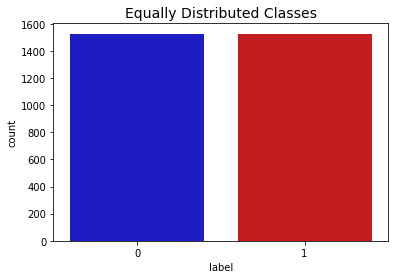

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['label'].value_counts()/len(new_df))


sns.countplot('label', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

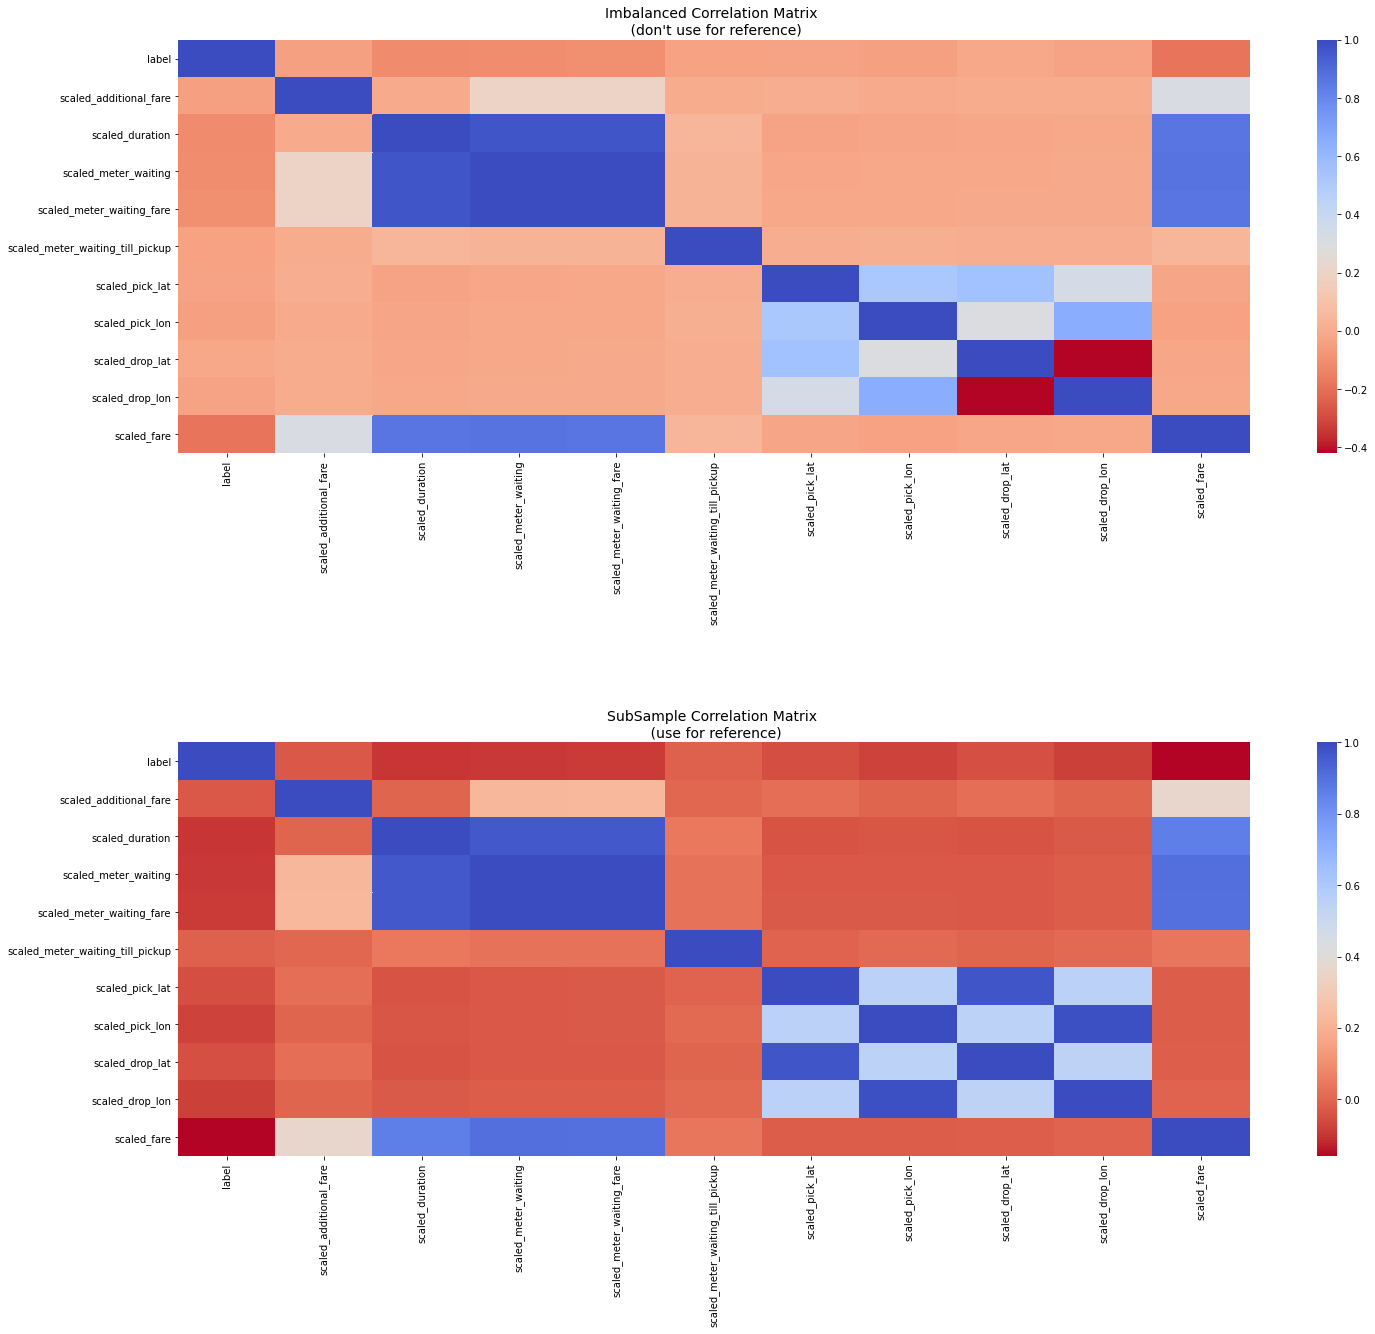

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.7)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

#print("-------------------------------------------------------------------------------")

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2,)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

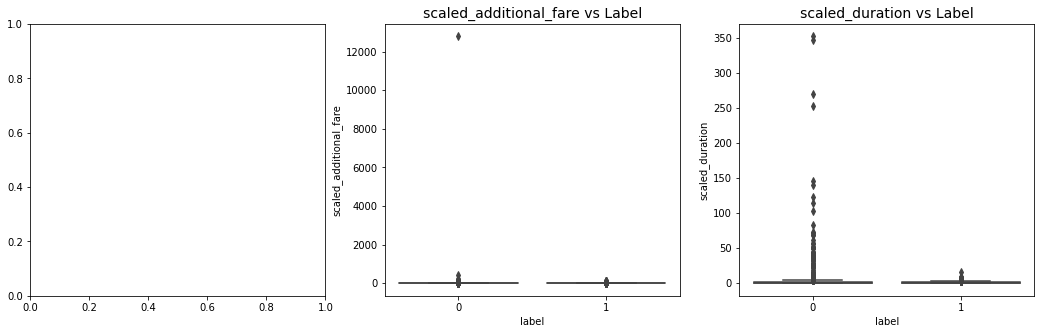

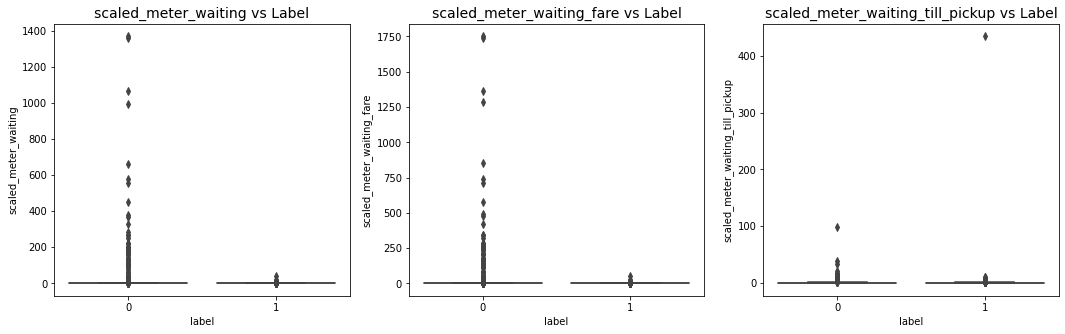

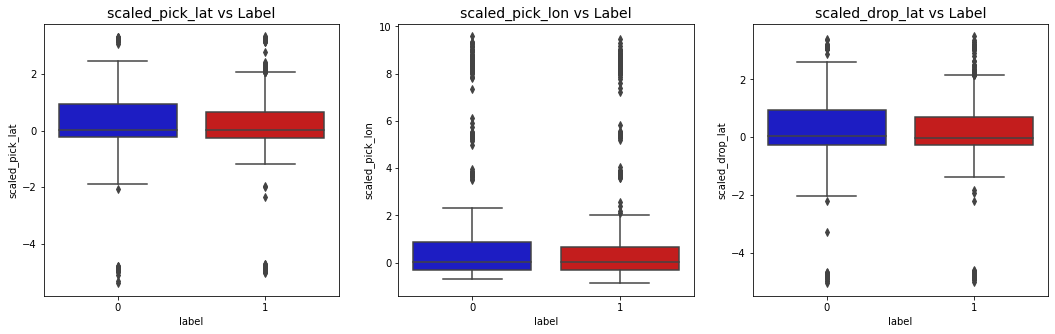

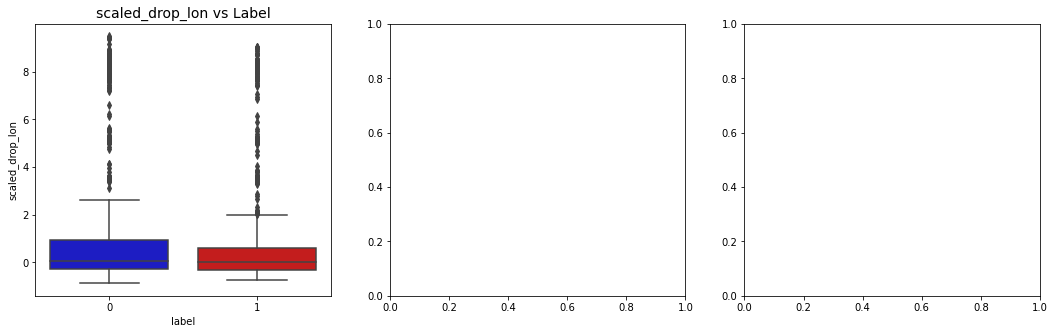

In [ ]:
columns = new_df.columns
for idx in range(0,12,3):
  fig, (ax) = plt.subplots(1, 3, figsize=(18,5))

  for k in range(0,3):
    if(columns[idx+k]=="label"):
      continue
    if(idx+k==10):
      break

    sns.boxplot(x="label", y=columns[idx+k], data=new_df, palette=colors, ax=ax[k])

    ax[k].set_title('{0} vs Label'.format(columns[idx+k]), fontsize=14)


plt.show()

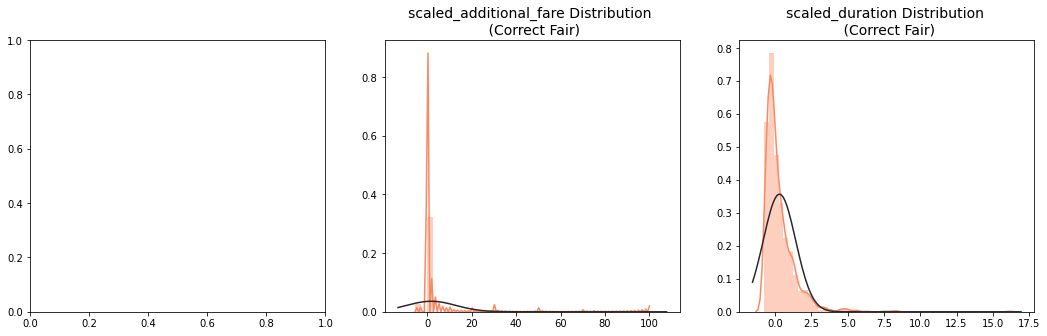

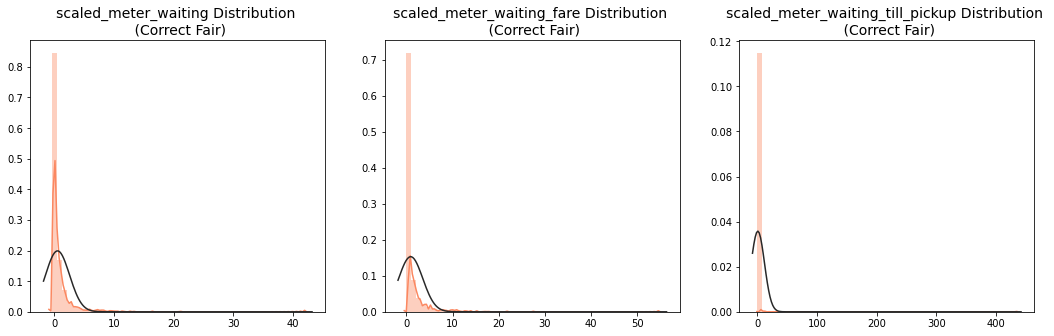

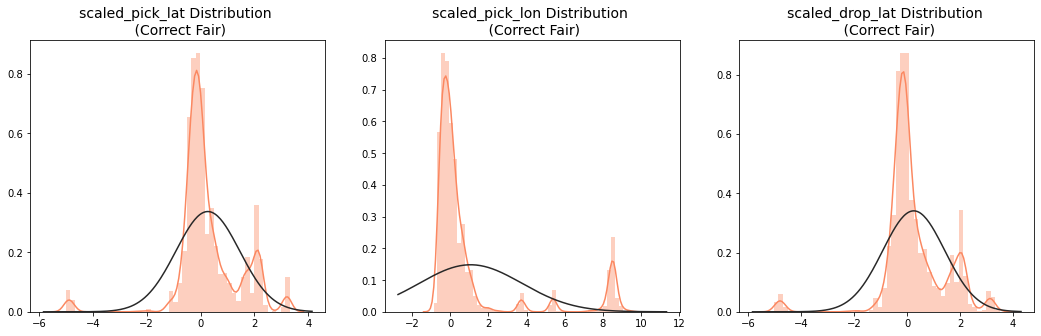

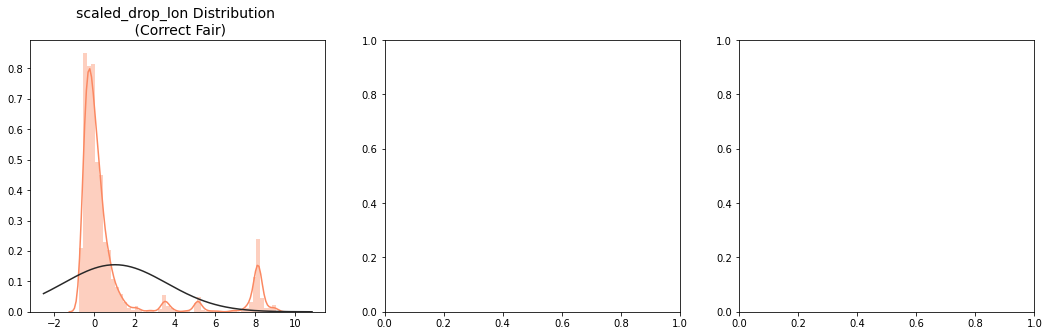

In [ ]:
from scipy.stats import norm

columns = new_df.columns
for idx in range(0,12,3):
  fig, (ax) = plt.subplots(1, 3, figsize=(18,5))

  for k in range(0,3):
    if(columns[idx+k]=="label"):
      continue
    if(idx+k==10):
      break

    correct_dist = new_df[columns[idx+k]].loc[new_df['label'] == 1].values
    sns.distplot(correct_dist, fit=norm, color='#FB8861',ax=ax[k])
    ax[k].set_title('{0} Distribution \n (Correct Fair)'.format(columns[idx+k]), fontsize=14)

plt.show()

In [ ]:
#Remove outliers from features

for column in columns:
  if(column=='label'):
    continue
  column_correct = new_df[column].loc[new_df['label'] == 1].values
  q25, q75 = np.percentile(column_correct, 25), np.percentile(column_correct, 75)
  print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
  _iqr = q75 - q25
  print('iqr: {}'.format(_iqr))

  _cut_off = _iqr * 1.5
  _lower, _upper = q25 - _cut_off, q75 + _cut_off
  print('Cut Off: {}'.format(_cut_off))
  print('{0} Lower: {1}'.format(column, _lower))
  print('{0} Upper: {1}'.format(column, _upper))

  outliers = [x for x in column_correct if x < _lower or x > _upper]
  print('Feature {0} Outliers for Fraud Cases: {1}'.format(column, len(outliers)))
  print('{0} outliers:{1}'.format(column, outliers))
  new_df = new_df.drop(new_df[(new_df[column] > _upper) | (new_df[column] < _lower)].index)
  print('Number of Instances after outliers removal: {}'.format(len(new_df)))
  print("-"*100)

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
scaled_additional_fare Lower: 0.0
scaled_additional_fare Upper: 0.0
Feature scaled_additional_fare Outliers for Fraud Cases: 216
scaled_additional_fare outliers:[-5.5, 20.0, 30.0, 50.0, 0.5, -5.5, -5.5, -5.5, -5.5, 14.5, 30.0, -5.5, 50.0, -5.5, -5.5, -5.5, 30.0, -5.5, -5.5, 50.0, -5.5, 50.0, 10.5, 100.0, 20.0, -5.5, 50.0, -5.5, 30.0, -5.5, -5.5, -5.5, -5.5, 30.0, -5.5, -5.5, 20.0, 50.0, 0.5, 20.0, 20.0, 20.0, -5.5, 81.0, 50.0, 30.0, 50.0, -5.5, -5.5, -5.5, -5.5, 50.0, 50.0, 50.0, 50.0, 50.0, 10.5, 20.0, -5.5, 50.0, 10.5, -5.5, -5.5, 70.0, -5.5, -5.5, 50.0, -5.5, -5.5, -5.5, 100.0, -5.5, -5.5, -5.5, 30.0, 20.0, 30.0, 20.0, 30.0, -5.5, -5.5, -5.5, -5.5, 20.0, -5.5, 20.0, -5.5, -5.5, -5.5, -5.5, -5.5, 70.0, 30.0, 50.0, 20.0, -5.5, -5.5, -5.5, -5.5, -5.5, 30.0, -5.5, 20.0, -5.5, 94.5, -0.5, 20.0, -5.5, 20.0, 70.0, 100.0, -5.5, -5.5, 20.0, -5.5, 100.0, -5.5, 30.0, -5.5, -5.5, 50.0, 20.0, -5.5, 30.0, 20.0, -5.5, -5.5, -5.5, -5.5, -5.5

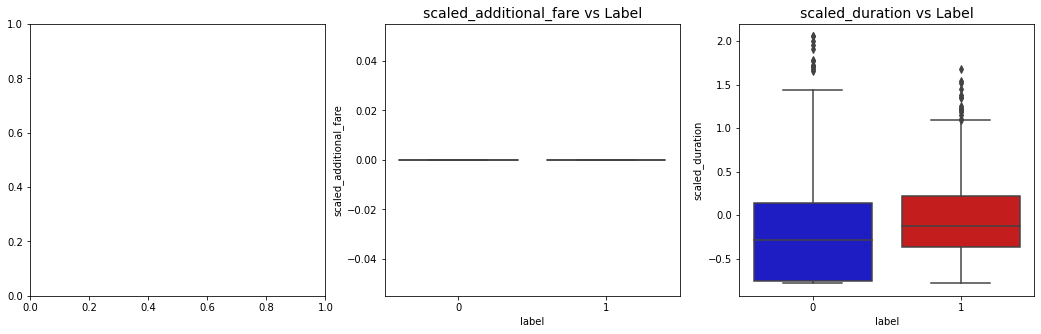

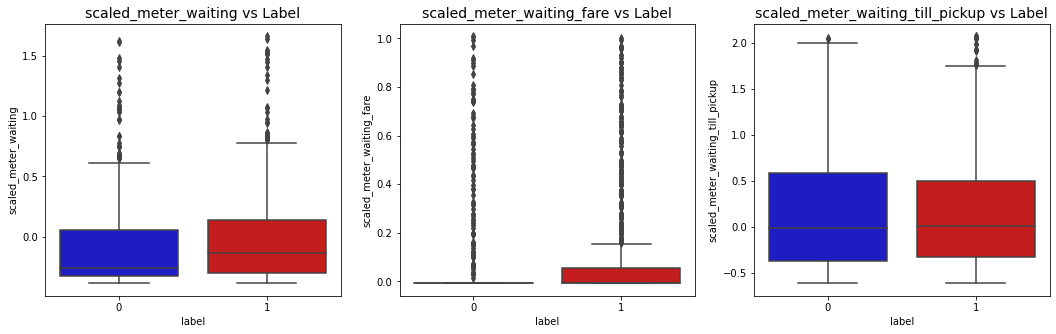

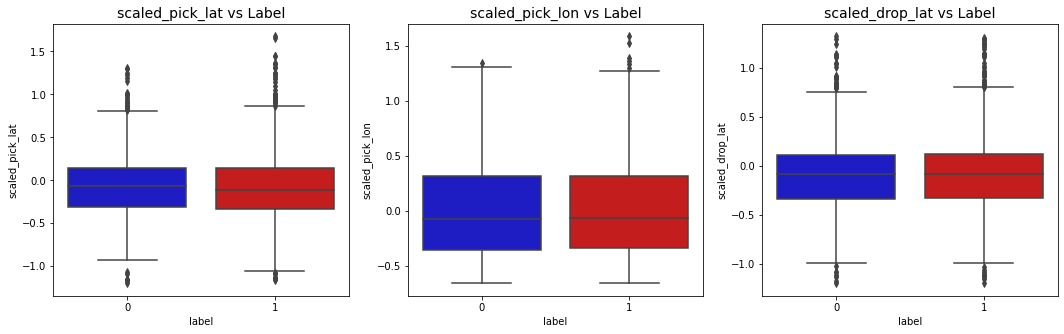

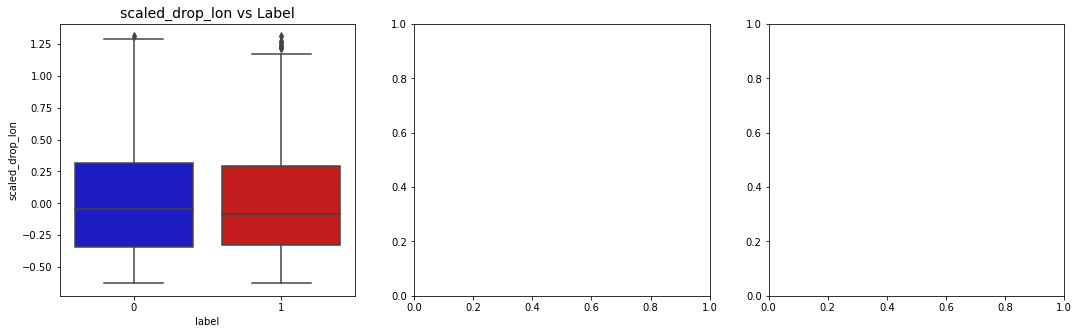

In [ ]:
columns = new_df.columns
for idx in range(0,12,3):
  fig, (ax) = plt.subplots(1, 3, figsize=(18,5))

  for k in range(0,3):
    if(columns[idx+k]=="label"):
      continue
    if(idx+k==10):
      break

    sns.boxplot(x="label", y=columns[idx+k], data=new_df, palette=colors, ax=ax[k])

    ax[k].set_title('{0} vs Label'.format(columns[idx+k]), fontsize=14)


plt.show()

In [ ]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('label', axis=1)
y = new_df['label']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))


T-SNE took 2.2e+01 s
PCA took 0.011 s
Truncated SVD took 0.01 s


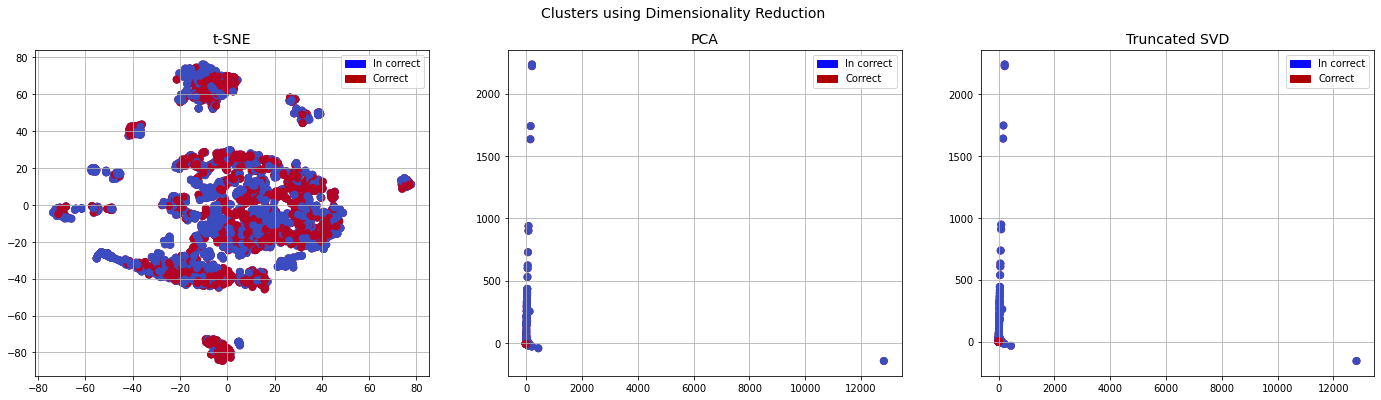

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='In correct')
red_patch = mpatches.Patch(color='#AF0000', label='Correct')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='In correct', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Corret', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='In Corret', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Corret', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='In Corret', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Corret', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('label', axis=1)
y = new_df['label']

In [ ]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [ ]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 68.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 75.0 % accuracy score
Classifiers:  SVC Has a training score of 55.00000000000001 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 75.0 % accuracy score


In [ ]:
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [ ]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  67.76%
Knears Neighbors Cross Validation Score 74.31%
Support Vector Classifier Cross Validation Score 69.32%
DecisionTree Classifier Cross Validation Score 72.39%


In [ ]:
undersample_X = df.drop('label', axis=1)
undersample_y = df['label']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 2970  2974  2993 ... 16965 16966 16967] Test: [   0    1    2 ... 3428 3429 3430]
Train: [    0     1     2 ... 16965 16966 16967] Test: [2970 2974 2993 ... 6785 6786 6799]
Train: [    0     1     2 ... 16965 16966 16967] Test: [ 6787  6788  6789 ... 10186 10187 10188]
Train: [    0     1     2 ... 16965 16966 16967] Test: [10091 10097 10119 ... 13600 13601 13602]
Train: [    0     1     2 ... 13600 13601 13602] Test: [13241 13266 13268 ... 16965 16966 16967]
NearMiss Label Distribution: Counter({0: 1526, 1: 1526})


In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

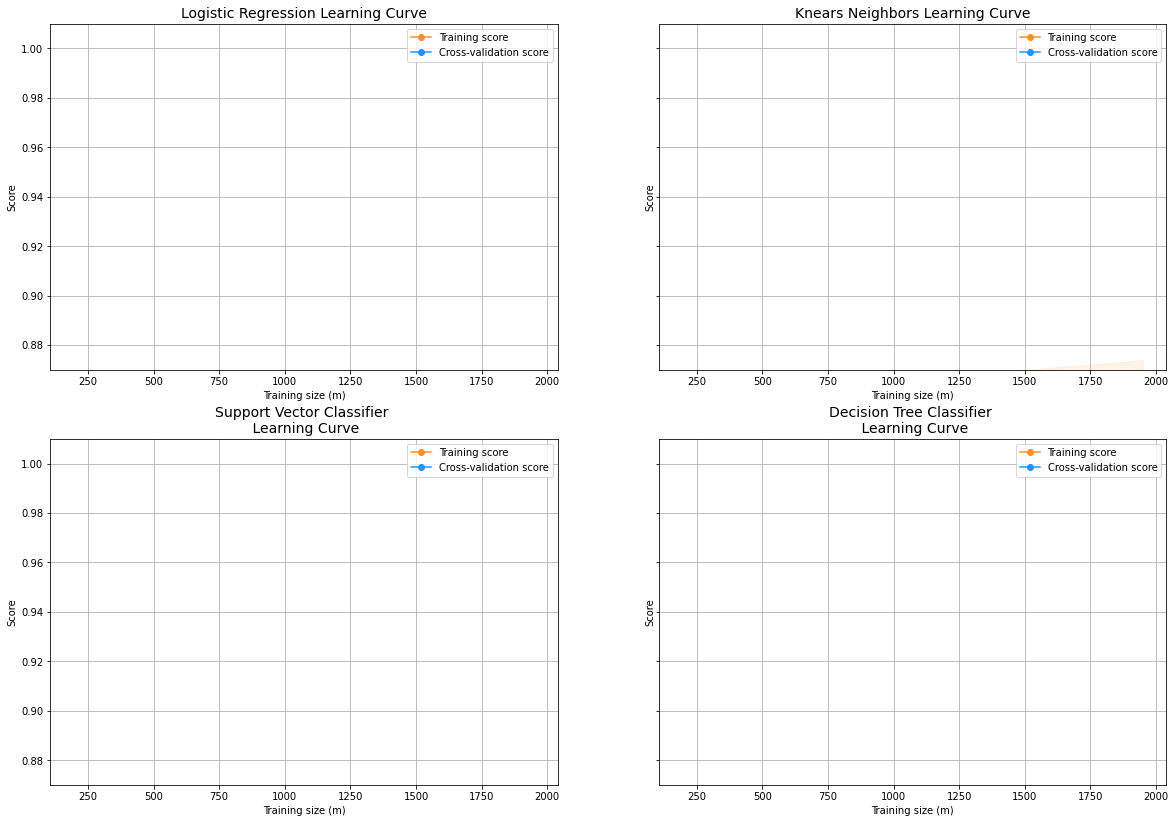

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)
